In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Libraries**

In [13]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



**Loading Data**

In [14]:
#Loading Data
data = pd.read_csv("drive/MyDrive/Kaggle/w13/traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


**Data Exploration**

In [15]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

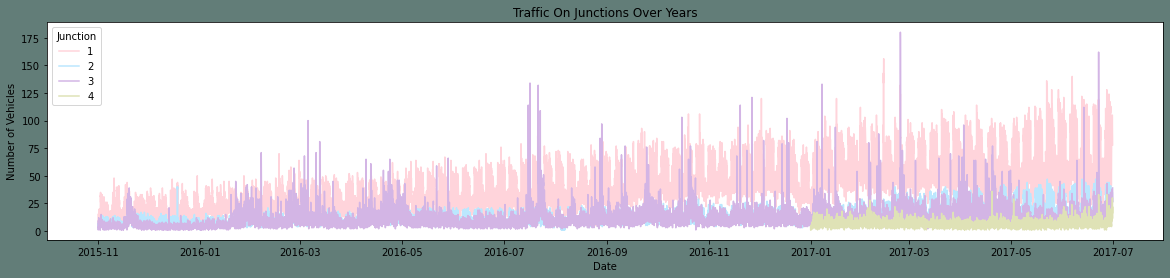

In [16]:
#df to be used for EDA
df=data.copy() 
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

**Feature Engineering**

In [17]:
#Exploring more features 
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


**Exploratory Data Analysis**

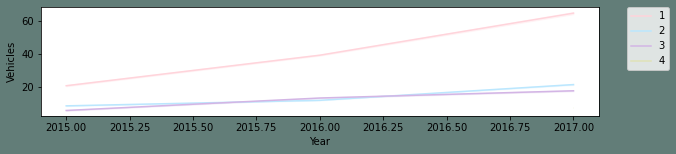

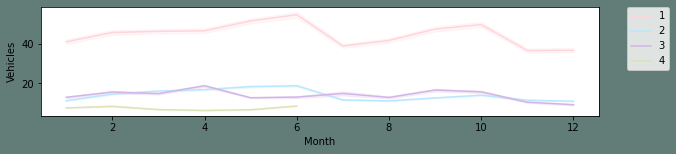

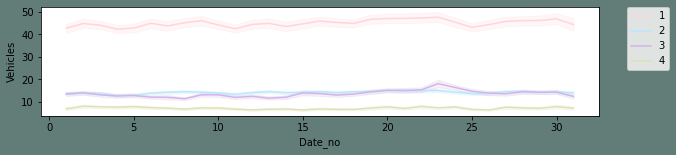

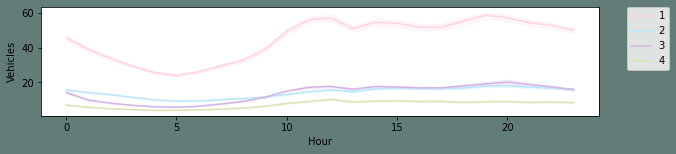

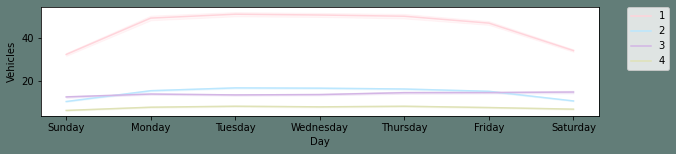

In [18]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

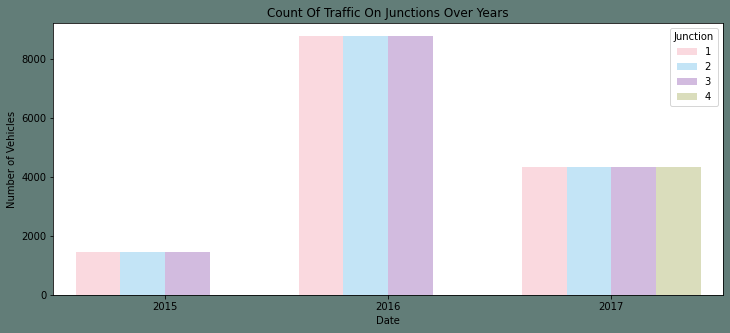

In [19]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

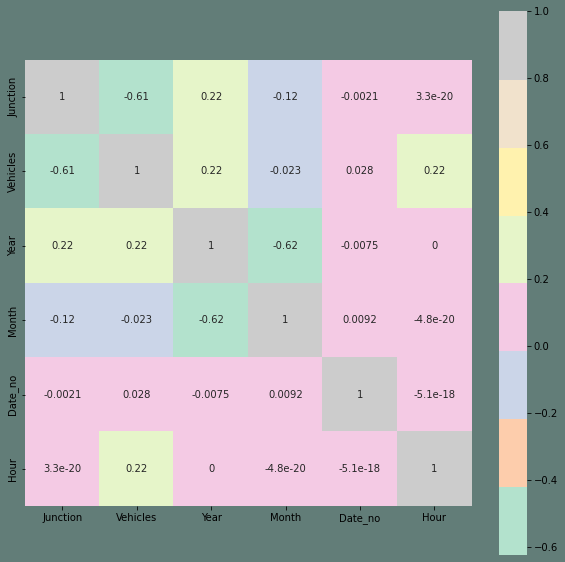

In [20]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

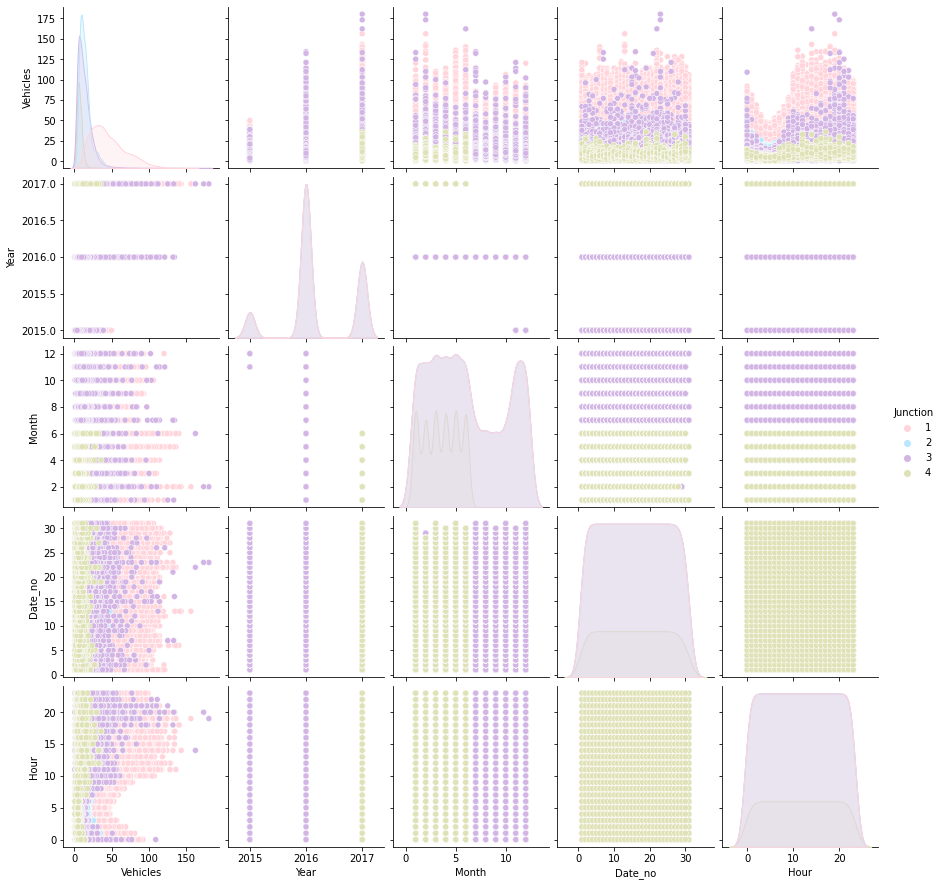

In [21]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

**Data Transformation And Preprocessing**

In [22]:
#Pivoting data fron junction 
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

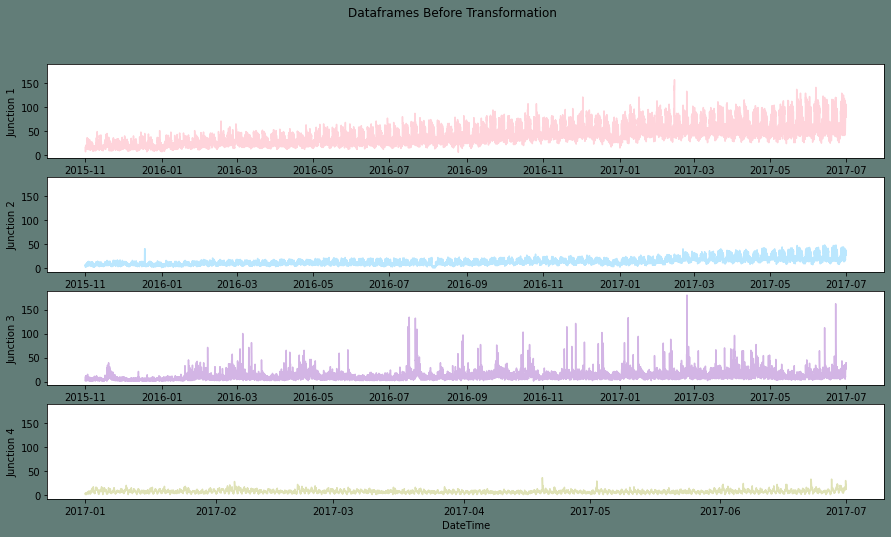

In [23]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

In [24]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [25]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

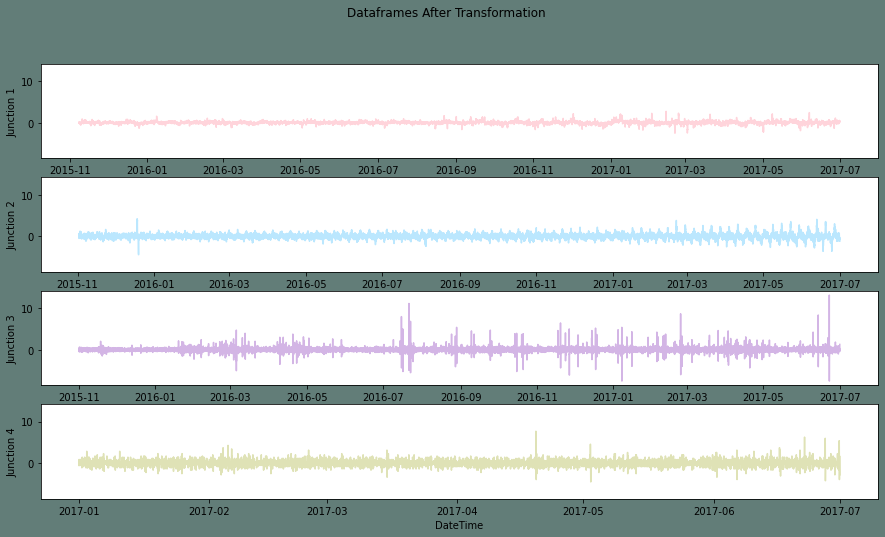

In [26]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

In [27]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415456
p-value: 4.798539876396407e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940122
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832987
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.97909256305222
p-value: 2.77878753259558e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [28]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

**Model Building**

In [29]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

**Fitting The Model**

In [30]:
#Predictions For First Junction
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/50
87/87 [==============================] - 40s 365ms/step - loss: 0.0736
Epoch 2/50
87/87 [==============================] - 32s 367ms/step - loss: 0.0655
Epoch 3/50
87/87 [==============================] - 32s 364ms/step - loss: 0.0635
Epoch 4/50
87/87 [==============================] - 32s 363ms/step - loss: 0.0619
Epoch 5/50
87/87 [==============================] - 31s 362ms/step - loss: 0.0610
Epoch 6/50
87/87 [==============================] - 31s 361ms/step - loss: 0.0597
Epoch 7/50
87/87 [==============================] - 32s 365ms/step - loss: 0.0584
Epoch 8/50
87/87 [==============================] - 32s 363ms/step - loss: 0.0576
Epoch 9/50
87/87 [==============================] - 31s 362ms/step - loss: 0.0568
Epoch 10/50
87/87 [==============================] - 32s 362ms/step - loss: 0.0568
Epoch 11/50
87/87 [==============================] - 32s 365ms/step - loss: 0.0559
Epoch 12/50
87/87 [==============================] - 32s 372ms/step - loss: 0.0556
Epoch 13/50
8

The root mean squared error is 0.24646660161314804.


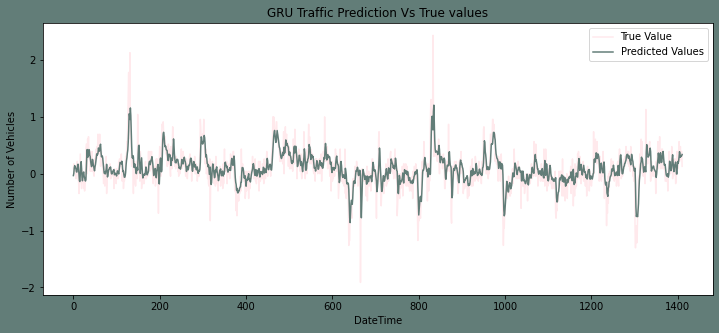

In [31]:
#Results for J1 
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

In [32]:
#Predictions For Second Junction
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)

Epoch 1/50
88/88 [==============================] - 42s 371ms/step - loss: 0.2306
Epoch 2/50
88/88 [==============================] - 33s 371ms/step - loss: 0.2072
Epoch 3/50
88/88 [==============================] - 33s 372ms/step - loss: 0.1979
Epoch 4/50
88/88 [==============================] - 32s 369ms/step - loss: 0.1957
Epoch 5/50
88/88 [==============================] - 32s 368ms/step - loss: 0.1927
Epoch 6/50
88/88 [==============================] - 33s 370ms/step - loss: 0.1930
Epoch 7/50
88/88 [==============================] - 33s 370ms/step - loss: 0.1912
Epoch 8/50
88/88 [==============================] - 33s 371ms/step - loss: 0.1912
Epoch 9/50
88/88 [==============================] - 33s 372ms/step - loss: 0.1891
Epoch 10/50
88/88 [==============================] - 33s 369ms/step - loss: 0.1882
Epoch 11/50
88/88 [==============================] - 33s 371ms/step - loss: 0.1880
Epoch 12/50
88/88 [==============================] - 32s 368ms/step - loss: 0.1873
Epoch 13/50
8

The root mean squared error is 0.5643767291794702.


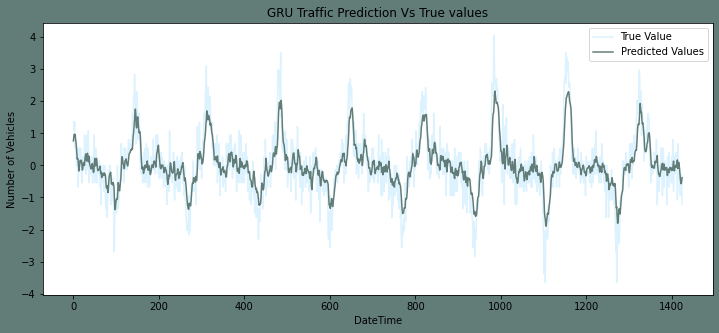

In [33]:
#Results for J2
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

In [34]:
#Predictions For Third Junction
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3) 

Epoch 1/50
88/88 [==============================] - 41s 367ms/step - loss: 0.3014
Epoch 2/50
88/88 [==============================] - 32s 366ms/step - loss: 0.2958
Epoch 3/50
88/88 [==============================] - 32s 367ms/step - loss: 0.2904
Epoch 4/50
88/88 [==============================] - 32s 366ms/step - loss: 0.2907
Epoch 5/50
88/88 [==============================] - 32s 365ms/step - loss: 0.2898
Epoch 6/50
88/88 [==============================] - 32s 366ms/step - loss: 0.2891
Epoch 7/50
88/88 [==============================] - 32s 367ms/step - loss: 0.2880
Epoch 8/50
88/88 [==============================] - 33s 371ms/step - loss: 0.2903
Epoch 9/50
88/88 [==============================] - 32s 369ms/step - loss: 0.2847
Epoch 10/50
88/88 [==============================] - 32s 367ms/step - loss: 0.2881
Epoch 11/50
88/88 [==============================] - 32s 365ms/step - loss: 0.2848
Epoch 12/50
88/88 [==============================] - 32s 367ms/step - loss: 0.2861
Epoch 13/50
8

The root mean squared error is 0.6073365118142606.


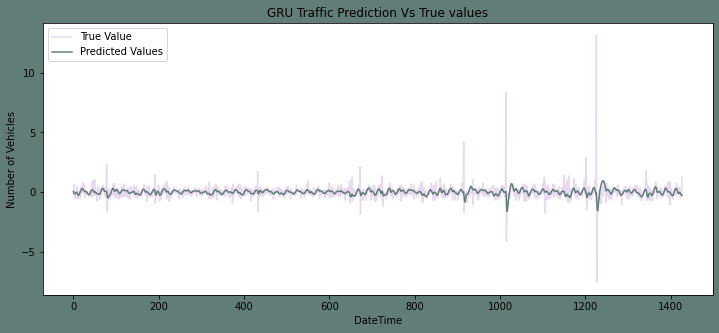

In [35]:
#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

In [36]:
#Predictions For Forth Junction
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)

Epoch 1/50
26/26 [==============================] - 19s 374ms/step - loss: 0.6923
Epoch 2/50
26/26 [==============================] - 10s 374ms/step - loss: 0.6883
Epoch 3/50
26/26 [==============================] - 10s 380ms/step - loss: 0.6971
Epoch 4/50
26/26 [==============================] - 10s 374ms/step - loss: 0.6874
Epoch 5/50
26/26 [==============================] - 10s 376ms/step - loss: 0.6852
Epoch 6/50
26/26 [==============================] - 10s 373ms/step - loss: 0.6816
Epoch 7/50
26/26 [==============================] - 10s 373ms/step - loss: 0.6825
Epoch 8/50
26/26 [==============================] - 10s 376ms/step - loss: 0.6796
Epoch 9/50
26/26 [==============================] - 10s 379ms/step - loss: 0.6819
Epoch 10/50
26/26 [==============================] - 10s 375ms/step - loss: 0.6805
Epoch 11/50
26/26 [==============================] - 10s 379ms/step - loss: 0.6794
Epoch 12/50
26/26 [==============================] - 10s 374ms/step - loss: 0.6793
Epoch 13/50
2

The root mean squared error is 1.0023076317127024.


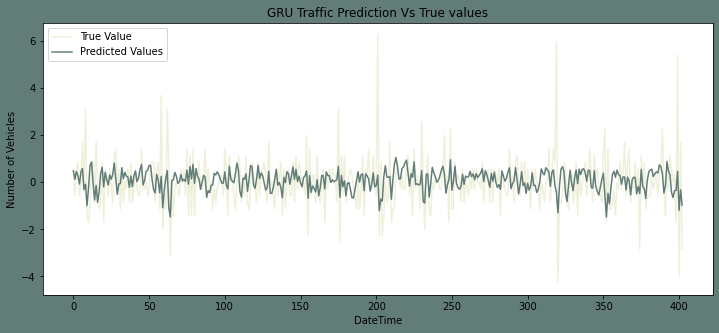

In [37]:
#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

**Inversing The Transformation Of Data**

In [38]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)
    
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")
    
    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

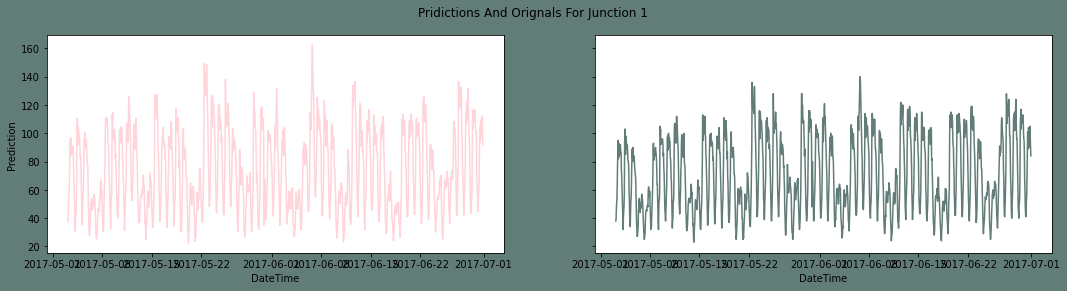

In [39]:
# invert the differenced forecast for Junction 1 
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

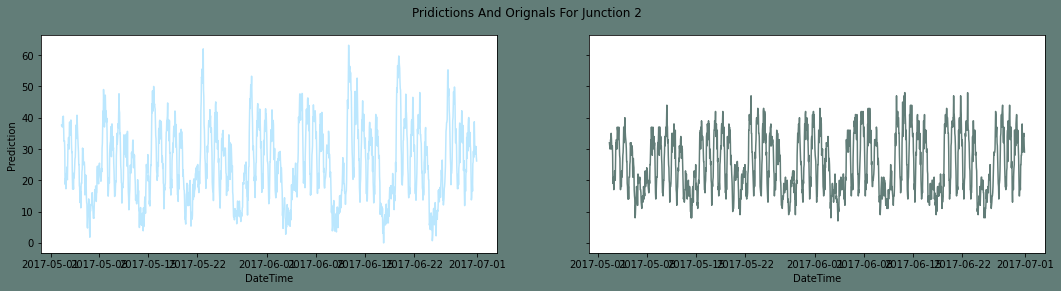

In [40]:
#Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

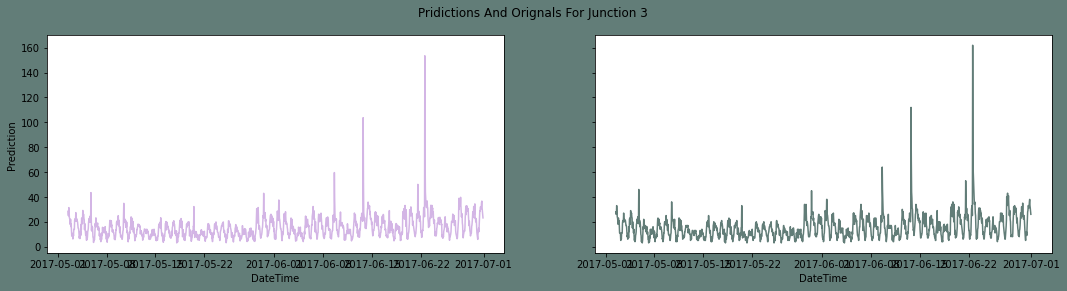

In [41]:
#Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

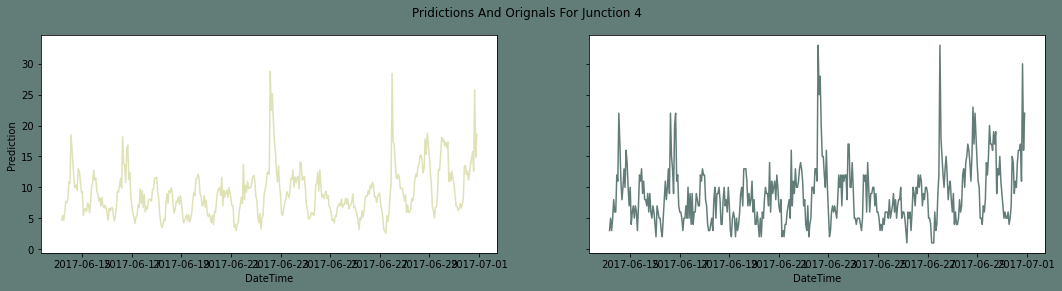

In [42]:
#Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)